### SINGAPORE DOLLAR (SGD)

In [46]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np
from tensorflow.keras.regularizers import L2
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

### DATA LOADING

In [4]:
df = pd.read_csv(r'/content/SGD-2001.csv')
df

,Date,Close
0,12/1/2003 23:58:00,4936.051565
1,12/2/2003 23:58:00,4933.778994
2,12/3/2003 23:58:00,4934.386066
3,12/4/2003 23:58:00,4956.229878
4,12/5/2003 23:58:00,4941.131840
...,...,...
7073,5/1/2024 23:58:00,11917.670000
7074,5/2/2024 23:58:00,11895.410000
7075,5/3/2024 23:58:00,11831.020000
7076,5/4/2024 23:58:00,11831.020000


### EDA

Text(0, 0.5, 'IDR')

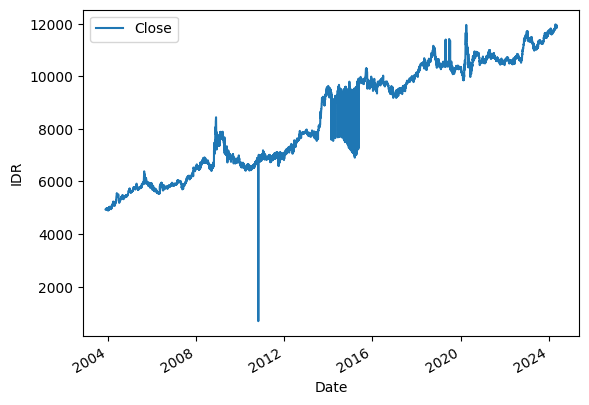

In [5]:
## PLOTTING THE DATA
df.columns = ['Date', 'Close']
df.Date = pd.to_datetime(df.Date)
df.set_index('Date',inplace=True)
df.plot()
plt.xlabel('Date')
plt.ylabel('IDR')

### FEATURE ENGINEERING

In [6]:
#splitting train and test
train=df[0:5000]
test=df[5000:]

train.head()

,Close
Date,
2003-12-01 23:58:00,4936.051565
2003-12-02 23:58:00,4933.778994
2003-12-03 23:58:00,4934.386066
2003-12-04 23:58:00,4956.229878
2003-12-05 23:58:00,4941.131840


### Moving Average Model

In [59]:
predictions = []

window_size = 14
for i in range(len(test)):
    if i < window_size:
        moving_avg = train['Close'].mean()
    else:
        moving_avg = train['Close'].iloc[-window_size:].mean()

    predictions.append(moving_avg)

    train = pd.concat([train, test.iloc[[i]]], ignore_index=True)

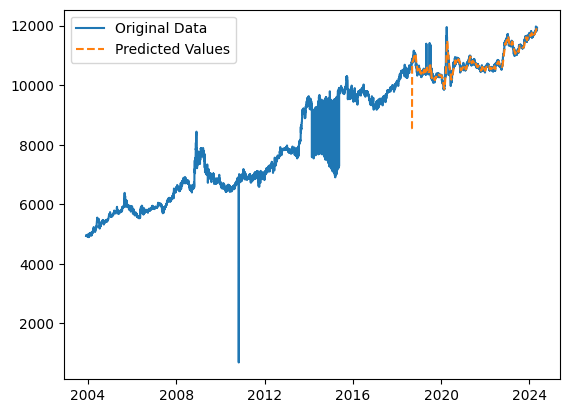

In [60]:
plt.plot(df['Close'], label='Original Data')
plt.plot(test.index, predictions, label='Predicted Values', linestyle='--')
plt.legend()
plt.show()

In [61]:
mae = mean_absolute_error(test.Close, predictions)
rmse = sqrt(mean_squared_error(test.Close, predictions))

# Menampilkan hasil
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 79.57731208864921
RMSE: 209.89479147285624


### ARIMA

In [10]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [11]:
check_stationarity(df['Close'])

ADF Statistic: -0.959478
p-value: 0.767756
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


In [12]:
## Perform first-order differencing
diff=df['Close'].diff()
diff

Date
2003-12-01 23:58:00          NaN
2003-12-02 23:58:00    -2.272571
2003-12-03 23:58:00     0.607072
2003-12-04 23:58:00    21.843812
2003-12-05 23:58:00   -15.098038
                         ...    
2024-05-01 23:58:00    -6.110000
2024-05-02 23:58:00   -22.260000
2024-05-03 23:58:00   -64.390000
2024-05-04 23:58:00     0.000000
2024-05-05 23:58:00    85.830000
Name: Close, Length: 7078, dtype: float64

In [13]:
print("1st order differencing")
check_stationarity(diff.dropna())

1st order differencing
ADF Statistic: -14.637492
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


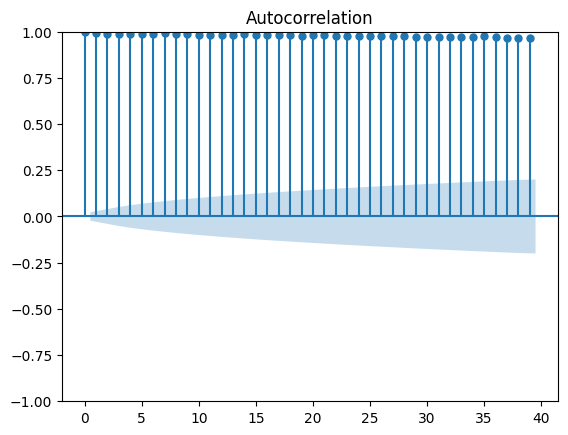

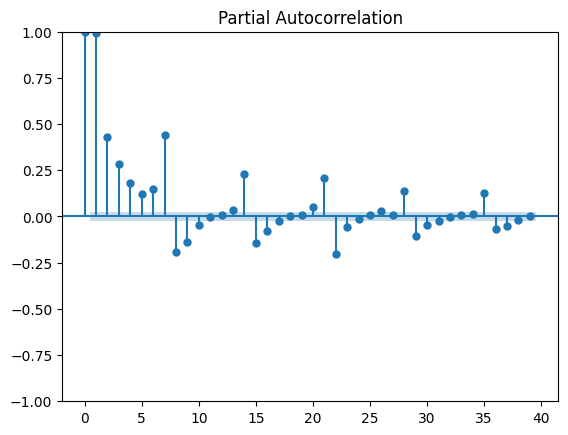

In [14]:
### ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Close'])
plot_pacf(df['Close'])
plt.show()

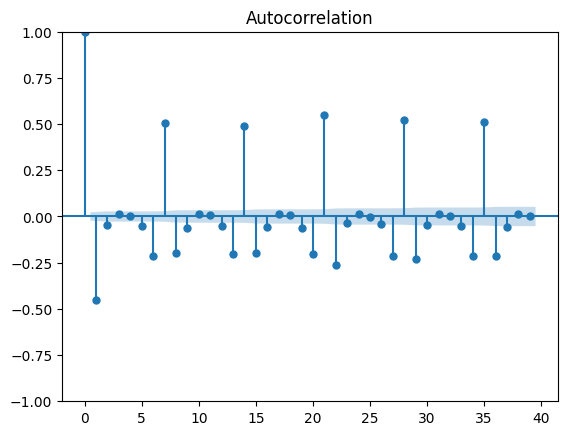

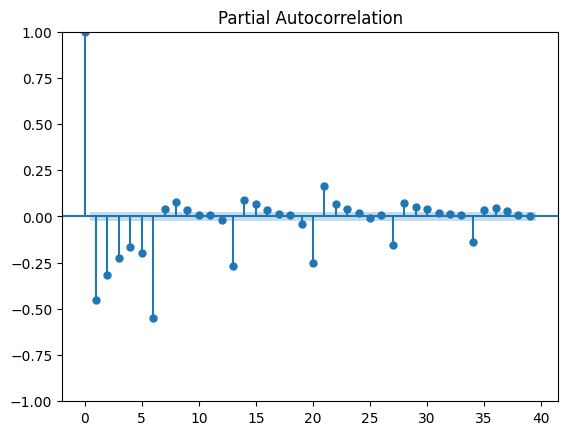

In [15]:
## ACF PACF DIFFERENCING
plot_acf(df['Close'].diff().dropna())
plot_pacf(df['Close'].diff().dropna())
plt.show()

- MA : 1,2,3,4,7,8
- AR : 0

>Potensi Model ARIMA :
ARIMA (0,0,1)
ARIMA (0,0,2)
ARIMA (0,0,3)
ARIMA (0,0,4)
ARIMA (0,0,7)
ARIMA (0,0,8)

In [ ]:
def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [ ]:
%%time
find_best_model(df['Close'], 3, 1, 40)

In [19]:
model_arima_singapore = ARIMA(df['Close'], order=(3, 1, 35))
result_model_arima_singapore = model_arima_singapore.fit()

print('The AIC is ', result_model_arima_singapore.aic)

The AIC is  93204.39471431993


In [20]:
df.head(10)

,Close
Date,
2003-12-01 23:58:00,4936.051565
2003-12-02 23:58:00,4933.778994
2003-12-03 23:58:00,4934.386066
2003-12-04 23:58:00,4956.229878
2003-12-05 23:58:00,4941.131840
2003-12-08 23:58:00,4963.878604
2003-12-09 23:58:00,4949.941508
2003-12-10 23:58:00,4960.443392
2003-12-11 23:58:00,4925.150185


In [21]:
new_pred1 = result_model_arima_singapore .predict(start="2003-12-1", end="2024-05-04", dynamic=False)
new_pred1 = pd.DataFrame(new_pred1)
new_pred1.columns = ['Close_predict']

all_dataset_with_pred1 = pd.concat([df, new_pred1], axis=1)
all_dataset_with_pred1.tail(50)

,Close,Close_predict
Date,,
2024-03-17 23:58:00,11701.32,11681.262821
2024-03-18 23:58:00,11764.49,11699.478676
2024-03-19 23:58:00,11722.77,11711.154378
2024-03-20 23:58:00,11723.80,11721.947063
2024-03-21 23:58:00,11703.63,11714.151419
2024-03-22 23:58:00,11723.63,11707.669841
2024-03-23 23:58:00,11723.63,11709.720793
2024-03-24 23:58:00,11723.63,11720.316849
2024-03-25 23:58:00,11737.00,11749.649979


In [22]:
len_dataset = df.shape[0]
len_predict = len_dataset + 12


new_pred = result_model_arima_singapore .predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns = ['Close_forecast']

last_date = df.index.max()
date_range = pd.date_range(start=last_date, periods=13)
new_pred.index = date_range
# Menggabungkan prediksi dengan dataset asli

all_dataset_with_pred = pd.concat([all_dataset_with_pred1, new_pred], axis=1)

In [23]:
all_dataset_with_pred

,Close,Close_predict,Close_forecast
2003-12-01 23:58:00,4936.051565,0.000000,NaN
2003-12-02 23:58:00,4933.778994,4738.981963,NaN
2003-12-03 23:58:00,4934.386066,4836.926721,NaN
2003-12-04 23:58:00,4956.229878,4865.780652,NaN
2003-12-05 23:58:00,4941.131840,4887.592263,NaN
...,...,...,...
2024-05-13 23:58:00,NaN,NaN,11913.062894
2024-05-14 23:58:00,NaN,NaN,11905.879127
2024-05-15 23:58:00,NaN,NaN,11897.897439
2024-05-16 23:58:00,NaN,NaN,11893.605132


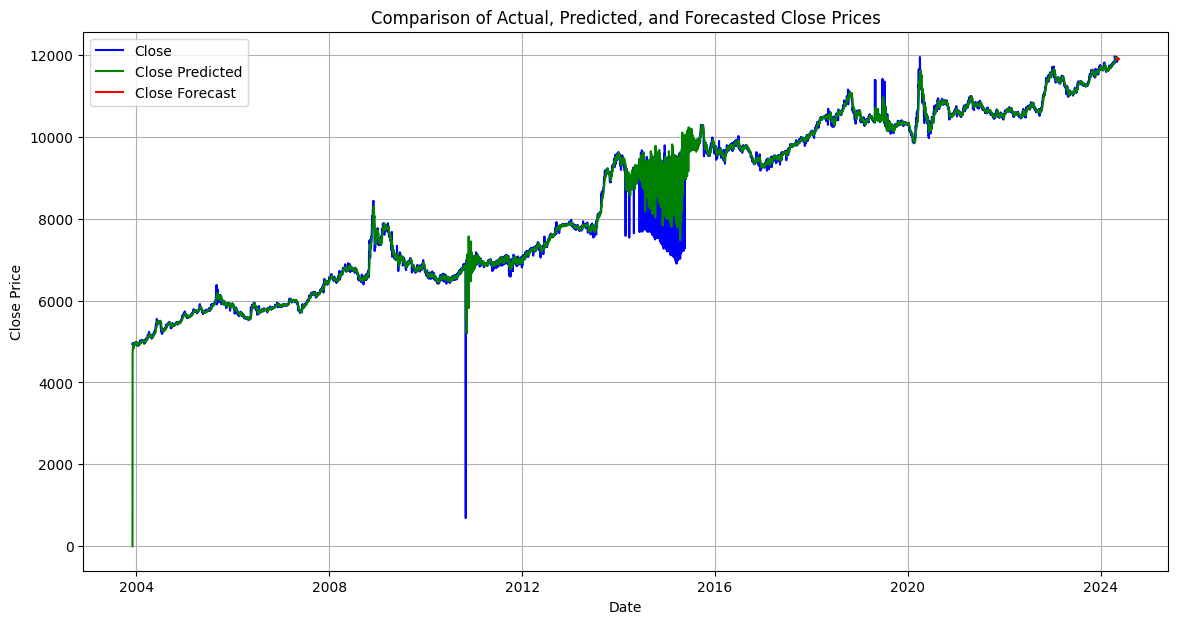

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close'], label='Close', color='blue', linestyle='-')  # Data asli
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_predict'], label='Close Predicted', color='green', linestyle='-')  # Data prediksi
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_forecast'], label='Close Forecast', color='red', linestyle='-')  # Data forecast

plt.title('Comparison of Actual, Predicted, and Forecasted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
valid_data=all_dataset_with_pred.dropna(subset=['Close', 'Close_predict'])
valid_data

,Close,Close_predict,Close_forecast
2003-12-01 23:58:00,4936.051565,0.000000,NaN
2003-12-02 23:58:00,4933.778994,4738.981963,NaN
2003-12-03 23:58:00,4934.386066,4836.926721,NaN
2003-12-04 23:58:00,4956.229878,4865.780652,NaN
2003-12-05 23:58:00,4941.131840,4887.592263,NaN
...,...,...,...
2024-04-30 23:58:00,11923.780000,11926.405653,NaN
2024-05-01 23:58:00,11917.670000,11923.025713,NaN
2024-05-02 23:58:00,11895.410000,11921.428382,NaN
2024-05-03 23:58:00,11831.020000,11917.465777,NaN


In [26]:
print('MAE test  : ', mean_absolute_error(valid_data['Close'], valid_data['Close_predict']))
print('RMSE test : ', np.sqrt(mean_squared_error(valid_data['Close'], valid_data['Close_predict'])))

MAE test  :  68.11539063844387
RMSE test :  177.21953832687305


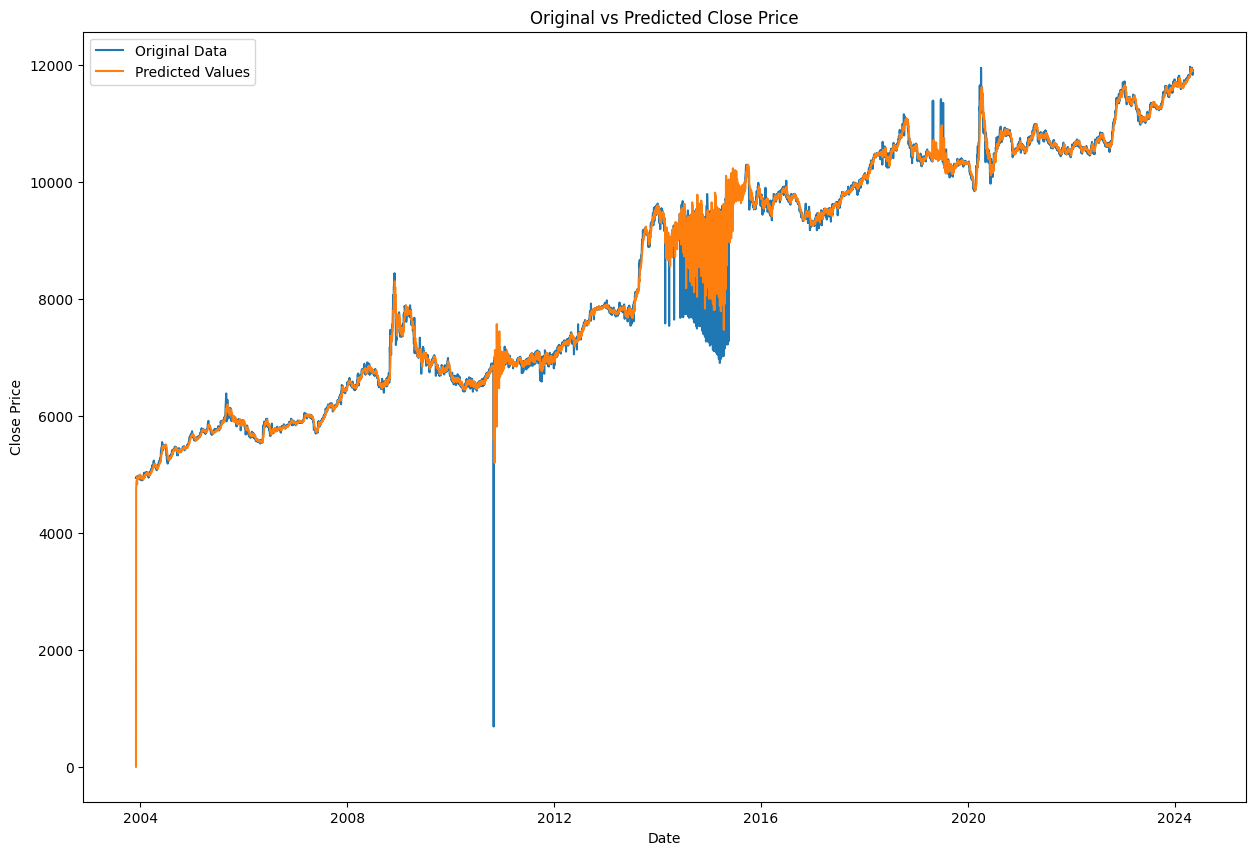

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Close'], label='Original Data')


# Plot predicted values overlapping the original data
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_predict'], label='Predicted Values', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Original vs Predicted Close Price')
plt.legend()
plt.show()

### LINEAR REGRESSION

In [29]:
df.head(10)

,Close
Date,
2003-12-01 23:58:00,4936.051565
2003-12-02 23:58:00,4933.778994
2003-12-03 23:58:00,4934.386066
2003-12-04 23:58:00,4956.229878
2003-12-05 23:58:00,4941.131840
2003-12-08 23:58:00,4963.878604
2003-12-09 23:58:00,4949.941508
2003-12-10 23:58:00,4960.443392
2003-12-11 23:58:00,4925.150185


In [30]:
df_reg = df.copy()
df_reg = df_reg.drop(['Close'], axis=1)
df_reg['lag_5'] = df['Close'].shift(5)
df_reg['lag_4'] = df['Close'].shift(4)
df_reg['lag_3'] = df['Close'].shift(3)
df_reg['lag_2'] = df['Close'].shift(2)
df_reg['lag_1'] = df['Close'].shift(1)
df_reg['y'] = df['Close']

# Menampilkan dataset
df_reg

,lag_5,lag_4,lag_3,lag_2,lag_1,y
Date,,,,,,
2003-12-01 23:58:00,NaN,NaN,NaN,NaN,NaN,4936.051565
2003-12-02 23:58:00,NaN,NaN,NaN,NaN,4936.051565,4933.778994
2003-12-03 23:58:00,NaN,NaN,NaN,4936.051565,4933.778994,4934.386066
2003-12-04 23:58:00,NaN,NaN,4936.051565,4933.778994,4934.386066,4956.229878
2003-12-05 23:58:00,NaN,4936.051565,4933.778994,4934.386066,4956.229878,4941.131840
...,...,...,...,...,...,...
2024-05-01 23:58:00,11917.63,11917.630000,11904.370000,11954.040000,11923.780000,11917.670000
2024-05-02 23:58:00,11917.63,11904.370000,11954.040000,11923.780000,11917.670000,11895.410000
2024-05-03 23:58:00,11904.37,11954.040000,11923.780000,11917.670000,11895.410000,11831.020000


In [31]:
# Melakukan pengecekan nilai null pada dataset
df_reg.isnull().sum()

lag_5    5
lag_4    4
lag_3    3
lag_2    2
lag_1    1
y        0
dtype: int64

In [32]:
# Melakukan dropping nilai null pada data
df_reg.dropna(inplace=True)

# Mengecek hasil dropping nilai null
df_reg.isnull().sum()

lag_5    0
lag_4    0
lag_3    0
lag_2    0
lag_1    0
y        0
dtype: int64

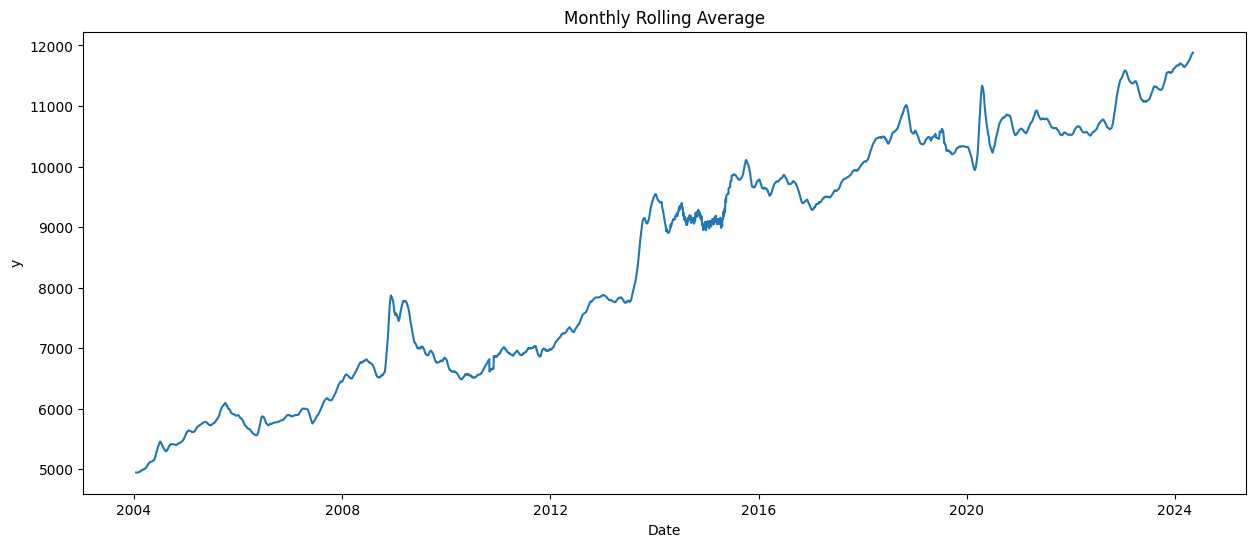

In [33]:
# Membuat visualisasi rolling per bulan
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df_reg.index, y = df_reg["y"].rolling(30).mean(), data = df_reg, ax=ax)
ax.set_title("Monthly Rolling Average");

In [34]:
# Mengecek korelasi
df_reg.corr()

,lag_5,lag_4,lag_3,lag_2,lag_1,y
lag_5,1.000000,0.990773,0.989914,0.989911,0.989681,0.989395
lag_4,0.990773,1.000000,0.990772,0.989913,0.989911,0.989680
lag_3,0.989914,0.990772,1.000000,0.990771,0.989912,0.989910
lag_2,0.989911,0.989913,0.990771,1.000000,0.990771,0.989911
lag_1,0.989681,0.989911,0.989912,0.990771,1.000000,0.990770
y,0.989395,0.989680,0.989910,0.989911,0.990770,1.000000


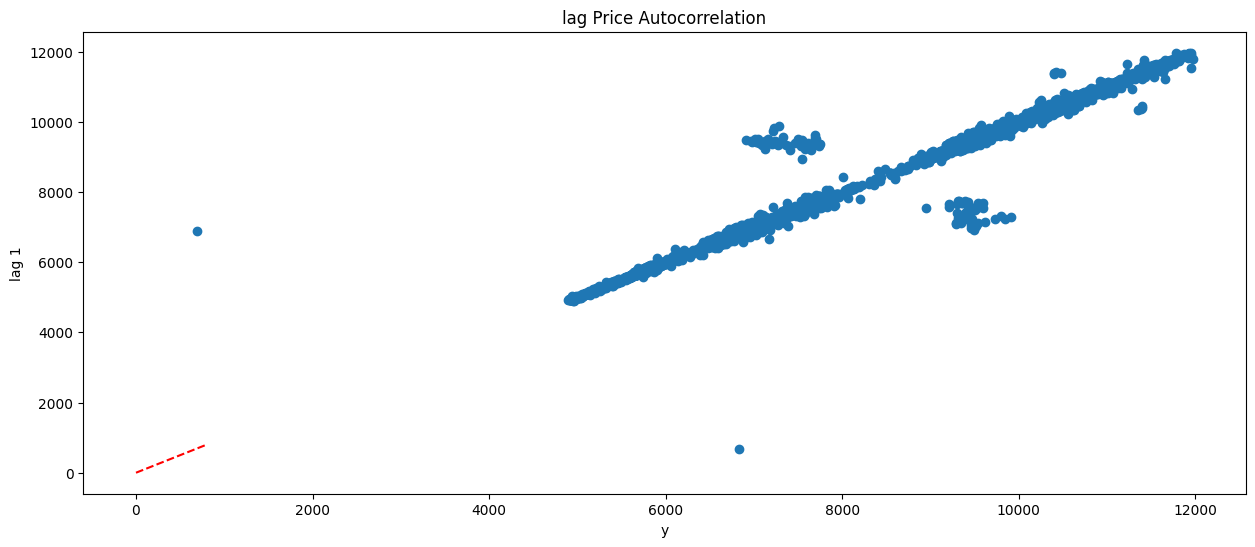

In [35]:
# Membuat visualisasi korelasi antara lag 0 dan lag 1
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=df_reg["y"], y=df_reg["lag_1"])
ax.plot([0,800],[0,800],linestyle="--", color="red")
plt.xlabel("y")
plt.ylabel("lag 1")
plt.title("lag Price Autocorrelation");

In [36]:
# Split the data menjadi fitur dan target
target = "y"
y = df_reg[target]
X = df_reg.drop(columns= target)

#Split the data into train and test sets
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

<Axes: xlabel='Date'>

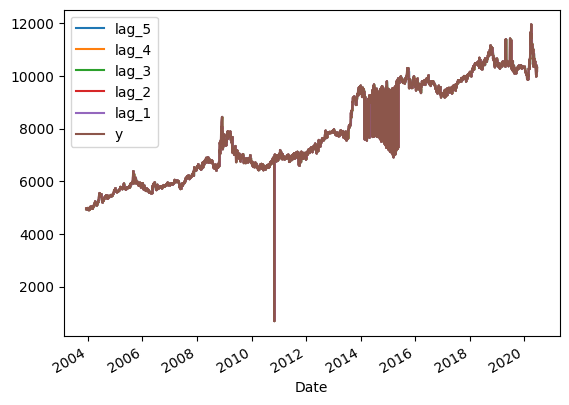

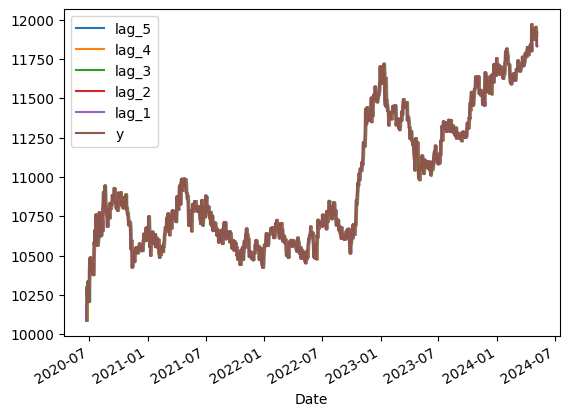

In [37]:
# Plotting data
df_reg[:len(X_train)].plot()
df_reg[len(X_train):].plot()

In [38]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close Prices:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close Prices: 7954.78
Baseline MAE: 1595.82


In [39]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [40]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 79.72
Test MAE: 34.85


In [41]:
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "y_pred": model.predict(X_test)
             }
)
df_pred_test.head()

,y_test,y_pred
Date,,
2020-06-21 23:58:00,10084.39,10231.560638
2020-06-22 23:58:00,10291.27,10187.777603
2020-06-23 23:58:00,10256.44,10213.195383
2020-06-24 23:58:00,10255.87,10201.712615
2020-06-25 23:58:00,10337.68,10216.802234


In [42]:
import plotly.express as px

fig = px.line(df_pred_test, labels= {"value": "Close Price"}, title = "Linear Regression Model: Actual Prices vs. Predicted Prices.")
fig.show()

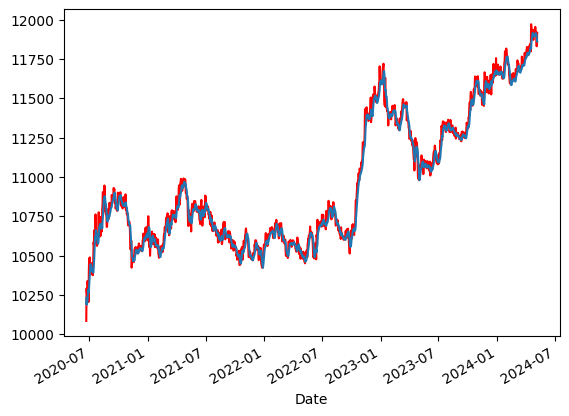

In [43]:
import matplotlib.pyplot as plt

df_pred_test['y_test'].plot(color='red')
plt.plot(df_pred_test['y_pred'])

In [44]:
print('MAE test  : ', mean_absolute_error(df_pred_test['y_test'], df_pred_test['y_pred']))
print('RMSE test : ', np.sqrt(mean_squared_error(df_pred_test['y_test'], df_pred_test['y_pred'])))

MAE test  :  34.848113448923236
RMSE test :  46.35754848529287


### LSTM

In [47]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_thb
model_thb = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=128, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=64, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_thb.compile(optimizer='adam', loss='mae', metrics=['mae']) # Notice the change here

# Display model_thb summary
model_thb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [48]:
history_thb = model_thb.fit(X_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
177/177 [==============================] - 7s 15ms/step - loss: 7836.1421 - mae: 7835.7490
Epoch 2/100
177/177 [==============================] - 3s 16ms/step - loss: 7238.7329 - mae: 7237.9922
Epoch 3/100
177/177 [==============================] - 3s 15ms/step - loss: 6066.0898 - mae: 6064.4121
Epoch 4/100
177/177 [==============================] - 3s 15ms/step - loss: 4298.6167 - mae: 4295.4175
Epoch 5/100
177/177 [==============================] - 3s 16ms/step - loss: 2347.0491 - mae: 2341.9255
Epoch 6/100
177/177 [==============================] - 3s 16ms/step - loss: 1737.7529 - mae: 1731.3536
Epoch 7/100
177/177 [==============================] - 3s 16ms/step - loss: 1669.4948 - mae: 1662.6705
Epoch 8/100
177/177 [==============================] - 3s 16ms/step - loss: 1670.5809 - mae: 1663.6862
Epoch 9/100
177/177 [==============================] - 3s 16ms/step - loss: 1673.2008 - mae: 1666.3020
Epoch 10/100
177/177 [==============================] - 3s 16ms/step - lo

In [55]:
predictions_lstm = model_thb.predict(X_test)

45/45 [==============================] - 0s 6ms/step


In [71]:
print('MAE test  : ', mean_absolute_error(y_test, predictions_lstm))
print('RMSE test : ', np.sqrt(mean_squared_error(y_test, predictions_lstm)))

MAE test  :  3259.754500060844
RMSE test :  3287.062298248364


### MODEL EVALUATION

In [62]:
all_reports = {}
def performance_report(all_reports, y_test, y_pred_test, name):
  score_reports = {
      'MAE test' : mean_absolute_error(y_test, y_pred_test),
      'RMSE test' : np.sqrt(mean_squared_error(y_test, y_pred_test)),
  }
  all_reports[name] = score_reports
  return all_reports


In [63]:
# Menambahkan hasil Logistic Regression ke dalam dictionary
all_reports = performance_report(all_reports, df_pred_test['y_test'], df_pred_test['y_pred'], 'Linear Regression')
pd.DataFrame(all_reports)

,Linear Regression
MAE test,34.848113
RMSE test,46.357548


In [64]:
# Menambahkan hasil Moving Average ke dalam dictionary
all_reports = performance_report(all_reports, test['Close'], predictions, 'Moving Average')
pd.DataFrame(all_reports)

,Linear Regression,Moving Average
MAE test,34.848113,79.577312
RMSE test,46.357548,209.894791


In [65]:
# Mengambil data untuk report arima
arima_report = all_dataset_with_pred.copy()
arima_report = arima_report.dropna(subset=['Close', 'Close_predict'])
arima_report

,Close,Close_predict,Close_forecast
2003-12-01 23:58:00,4936.051565,0.000000,NaN
2003-12-02 23:58:00,4933.778994,4738.981963,NaN
2003-12-03 23:58:00,4934.386066,4836.926721,NaN
2003-12-04 23:58:00,4956.229878,4865.780652,NaN
2003-12-05 23:58:00,4941.131840,4887.592263,NaN
...,...,...,...
2024-04-30 23:58:00,11923.780000,11926.405653,NaN
2024-05-01 23:58:00,11917.670000,11923.025713,NaN
2024-05-02 23:58:00,11895.410000,11921.428382,NaN
2024-05-03 23:58:00,11831.020000,11917.465777,NaN


In [66]:
# Menambahkan hasil ARIMA ke dalam dictionary
all_reports = performance_report(all_reports, arima_report['Close'], arima_report['Close_predict'], 'ARIMA')
pd.DataFrame(all_reports)

,Linear Regression,Moving Average,ARIMA
MAE test,34.848113,79.577312,68.115391
RMSE test,46.357548,209.894791,177.219538


In [67]:
# Menambahkan hasil LSTM ke dalam dictionary
all_reports = performance_report(all_reports, y_test, predictions_lstm, 'LSTM')
pd.DataFrame(all_reports)

,Linear Regression,Moving Average,ARIMA,LSTM
MAE test,34.848113,79.577312,68.115391,3259.754500
RMSE test,46.357548,209.894791,177.219538,3287.062298


Untuk evaluasi model. Kita melihat nilai MAE dan RMSE yang paling kecil. Dimana dapat terlihat bahwa dari nilai MAE dan RMSE model Linear Regression adalah model terbaik dalam memprediksi kurs dari Singapore Dollar

### FURTHER ANALYSIS

Dilakukan sebuah perbandingan min dan max test set dengan hasil prediksi

In [68]:
# Melihat data hasil
hasil = df_pred_test.copy()
hasil.head()

,y_test,y_pred
Date,,
2020-06-21 23:58:00,10084.39,10231.560638
2020-06-22 23:58:00,10291.27,10187.777603
2020-06-23 23:58:00,10256.44,10213.195383
2020-06-24 23:58:00,10255.87,10201.712615
2020-06-25 23:58:00,10337.68,10216.802234


In [69]:
# Melihat min dan max dari data menggunakan describe
hasil.describe()

,y_test,y_pred
count,1415.000000,1415.000000
mean,10966.626570,10954.302090
std,422.972324,419.514318
min,10084.390000,10187.777603
25%,10616.560000,10610.309108
50%,10790.790000,10786.171265
75%,11341.660000,11325.074399
max,11970.770000,11915.391133


In [70]:
jum_lower_data = hasil[(hasil['y_pred']<hasil['y_test'])].count()
print(f"Jumlah data y_pred lebih kecil dari y_test asli adalah {jum_lower_data[0]}")
print("Keseluruhan jumlah data adalah ", len(hasil))
print("Persentase jumlah data lebih kecil adalah ", (jum_lower_data[0]/len(hasil))*100, "%")

Jumlah data y_pred lebih kecil dari y_test asli adalah 863
Keseluruhan jumlah data adalah  1415
Persentase jumlah data lebih kecil adalah  60.98939929328622 %


Terlihat bahwa presentase jumlah data lebih kecil adalah 60% dari data asli. Sehingga dapat disarankan untuk pengguna kalkulator untuk menyiapkan uang yang lebih dari hasil prediksi kami  

### MODEL SAVING

In [45]:
model_pkl_file = "bea_cukai_sgd_linreg.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)